In [1]:
# data analysis and wrangling

import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import hist
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# prettify
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Data Dictionary
VariableDefinitionKey 
**survival**: Survival 0 = No, 1 = Yes <br>
**pclass**: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd <br>
**sex**: Sex Age Age in years <br>
**sibsp**: # of siblings / spouses aboard the Titanic <br>
**parch**: # of parents / children aboard the Titanic <br>
**ticket**: Ticket number <br>
**fare**: Passenger fare <br>
**cabin**: Cabin number <br>
**embarked**: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton<br>
<br><br>

### Variable Notes
**pclass**: A proxy for socio-economic status (SES)<br>
* 1st = Upper<br>
* 2nd = Middle<br>
* 3rd = Lower<br>

**age**: Age<br> 
Fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>

**sibsp**: The dataset defines family relations in this way...<br>
* **Sibling** = brother, sister, stepbrother, stepsister<br>
* **Spouse** = husband, wife (mistresses and fiancés were ignored)<br>

**parch**: The dataset defines family relations in this way...<br>
* **Parent** = mother, father<br>
* **Child** = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>

### Load Data & Combine

In [2]:
dat={}

dat["train"]=pd.read_csv('train.csv')
dat["test"]=pd.read_csv('test.csv')

### Add Data

In [3]:
for s in dat:
    dat[s]['Title'] = dat[s].Name.str.extract(' ([A-Za-z]+)\.', expand=False)

### Drop useless data

In [4]:
for s in dat:
    dat[s] = dat[s].drop(['Ticket', 'Cabin','Embarked'], axis=1)
    
for s in dat:
    dat[s].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,Mr


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,Mrs


### Attempt to fill in missing data

<br>

#### Start by filling in the missing ages by using their title
#### Then fill in the fare with just a mean


In [28]:
for s in dat:
    #print("What columns have null values?")
    #dat[s].isnull().any()

    meanDict={}
    for title in dat[s]['Title'].unique():
        ages=dat[s]["Age"].where(dat[s]['Title']==title)
        mean=np.nanmean(ages)
        meanDict[title]=mean
    
    # break up dat[s] set
    dat[s]["Age"]=dat[s]["Age"].fillna(-1)
    missingAges = dat[s][dat[s]['Age']<0]
    dat[s] = dat[s][(dat[s]['Age']>=0)]

    # recombine everything
    for title in meanDict:
        titleAges = missingAges[missingAges['Title']==title]
        titleAges['Age'] =  meanDict[title]
        dat[s] = pd.concat([dat[s],titleAges])

    # for the fare, we are just going to do a mean across all tickets
    mean=np.nanmean(dat[s]["Fare"])
    dat[s]["Fare"]=dat[s]["Fare"].fillna(mean)
    
    # if there are any straggling ages, such as titles with no ages at all, do a mean
    mean=np.nanmean(dat[s]["Age"])
    dat[s]["Age"]=dat[s]["Age"].fillna(mean)
    #dat[s].isnull().any()

## Apply some normalization to the titles

,Title,Survived
0,Bourgeoisie,0.347826
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651


Women, Little Girls, Little Boys, The Rich, then the men


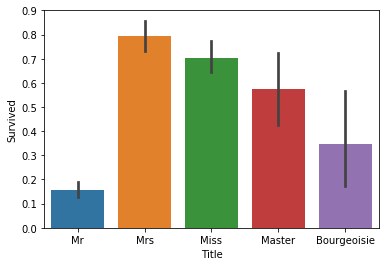

In [6]:
for s in dat:
    dat[s]['Title'] = dat[s]['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Bourgeoisie')

    dat[s]['Title'] = dat[s]['Title'].replace('Mlle', 'Miss')
    dat[s]['Title'] = dat[s]['Title'].replace('Ms', 'Miss')
    dat[s]['Title'] = dat[s]['Title'].replace('Mme', 'Mrs')
    
dat['train'][['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

sns.barplot(x='Title', y='Survived', data=dat['train'])
print("Women, Little Girls, Little Boys, The Rich, then the men")

### Drop Names now that we don't need them

In [7]:
for s in dat:
    # drop useless data
    dat[s] = dat[s].drop(['Name'], axis=1)
    dat[s].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title
0,1,0,3,male,22.0,1,0,7.2500,Mr
1,2,1,1,female,38.0,1,0,71.2833,Mrs
2,3,1,3,female,26.0,0,0,7.9250,Miss
3,4,1,1,female,35.0,1,0,53.1000,Mrs
4,5,0,3,male,35.0,0,0,8.0500,Mr


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title
0,892,3,male,34.5,0,0,7.8292,Mr
1,893,3,female,47.0,1,0,7.0000,Mrs
2,894,2,male,62.0,0,0,9.6875,Mr
3,895,3,male,27.0,0,0,8.6625,Mr
4,896,3,female,22.0,1,1,12.2875,Mrs


### Some Stats

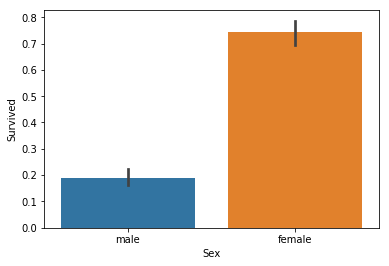

In [8]:
sns.barplot(x='Sex', y='Survived', data=dat['train'])

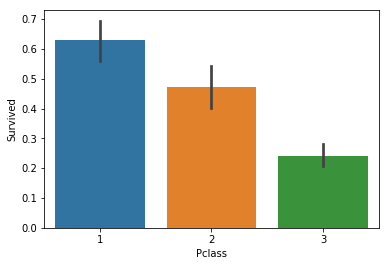

In [9]:
sns.barplot(x='Pclass', y='Survived', data=dat['train'])

In [10]:
import statsmodels.formula.api as sm
lm = sm.ols(formula='Survived~Pclass+Sex+Age+SibSp+Parch+Fare+Title', data=dat['train']).fit()
#lm.summary()

### Let's convert some strings to numbers
<br>
Logistical Regression requires this.

In [11]:
for s in dat:
    dat[s]['Sex'].replace(['male','female'],[0,1],inplace=True)
    dat[s]['Title'].replace(['Bourgeoisie','Mrs','Miss','Master','Mr'],[5,4,3,2,1],inplace=True)

dat['train'].head()
dat['test'].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title
0,1,0,3,0,22.0,1,0,7.2500,1
1,2,1,1,1,38.0,1,0,71.2833,4
2,3,1,3,1,26.0,0,0,7.9250,3
3,4,1,1,1,35.0,1,0,53.1000,4
4,5,0,3,0,35.0,0,0,8.0500,1


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title
0,892,3,0,34.5,0,0,7.8292,1
1,893,3,1,47.0,1,0,7.0000,4
2,894,2,0,62.0,0,0,9.6875,1
3,895,3,0,27.0,0,0,8.6625,1
4,896,3,1,22.0,1,1,12.2875,4


### Let's split up the training set

In [13]:
X_train = dat['train'].drop("Survived",axis=1)
Y_train = dat['train']["Survived"]
X_test  = dat['test'].copy()
X_test.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title
0,892,3,0,34.5,0,0,7.8292,1
1,893,3,1,47.0,1,0,7.0000,4
2,894,2,0,62.0,0,0,9.6875,1
3,895,3,0,27.0,0,0,8.6625,1
4,896,3,1,22.0,1,1,12.2875,4
5,897,3,0,14.0,0,0,9.2250,1
6,898,3,1,30.0,0,0,7.6292,3
7,899,2,0,26.0,1,1,29.0000,1
8,900,3,1,18.0,0,0,7.2292,4
9,901,3,0,21.0,2,0,24.1500,1


In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred1 = logreg.predict(X_test)

print("Logistic Regression Score ------------------------")
logreg.score(X_train, Y_train)

C:\Users\agust\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Score ------------------------


0.8013468013468014

In [18]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred2 = decision_tree.predict(X_test)

print("Decision Tree Score ------------------------")
decision_tree.score(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Decision Tree Score ------------------------


1.0

# Perfect!

In [25]:
submission = pd.DataFrame({
        "PassengerId": dat['test']["PassengerId"],
        "Survived": Y_pred1
    })
submission.to_csv('submission_log.csv', index=False)

submission = pd.DataFrame({
        "PassengerId": dat['test']["PassengerId"],
        "Survived": Y_pred2
    })
submission.to_csv('submission.csv', index=False)